<a href="https://colab.research.google.com/github/bouteldjadjihane/3d-unet-image-to-image-translation/blob/main/3D_UNet_MRI_CT_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#################################################  THE CODE FOR 80 EPOCHS ###############################################################

# from google.colab import drive
# drive.mount('/content/drive')

# from glob import glob
# import os
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader, Subset, random_split
# from tqdm.notebook import tqdm
# import nibabel as nib
# import numpy as np
# from skimage.metrics import peak_signal_noise_ratio, structural_similarity


# # CHECKPOINT

# def safe_torch_load(path, device):
#     """Handles partial/corrupted downloads from Drive"""
#     try:
#         return torch.load(path, map_location=device)
#     except:
#         print(f"⚠️ Corrupted checkpoint {path}, trying to recover...")
#         checkpoints = [f for f in os.listdir(os.path.dirname(path))
#                      if f.endswith('.pt') and f != os.path.basename(path)]
#         if checkpoints:
#             latest_good = sorted(checkpoints)[-1]
#             print(f"Loading {latest_good} instead")
#             return torch.load(os.path.join(os.path.dirname(path), latest_good), map_location=device)
#         raise

# def get_last_complete_epoch(checkpoint_dir):
#     """Finds the last fully saved epoch"""
#     checkpoints = [f for f in os.listdir(checkpoint_dir)
#                   if f.startswith('epoch_') and f.endswith('.pt')]
#     if not checkpoints:
#         return 0
#     epochs = [int(f.split('_')[1].split('.')[0]) for f in checkpoints]
#     return max(epochs)




# class BrainMRICTDataset(Dataset):
#     def __init__(self, patient_dirs, target_shape=(128,128,128), device='cpu'):
#         self.patient_dirs = patient_dirs
#         self.target_shape = target_shape
#         self.device = device

#     def __len__(self):
#         return len(self.patient_dirs)

#     def load_nii(self, path):
#         return nib.load(path).get_fdata().astype(np.float32)

#     def z_score_normalize(self, volume, mask=None):
#         if mask is not None:
#             values = volume[mask > 0]
#             mean = values.mean()
#             std = values.std()
#         else:
#             mean = volume.mean()
#             std = volume.std()
#         return (volume - mean) / (std + 1e-8)

#     def clip_and_scale_ct(self, ct, min_hu=-1000, max_hu=2000):
#         ct = np.clip(ct, min_hu, max_hu)
#         ct = 2 * (ct - min_hu) / (max_hu - min_hu) - 1
#         return ct

#     def crop_center(self, volume):
#         current_shape = volume.shape
#         start = [(c - t) // 2 for c, t in zip(current_shape, self.target_shape)]
#         end = [start[i] + self.target_shape[i] for i in range(3)]
#         return volume[start[0]:end[0], start[1]:end[1], start[2]:end[2]]

#     def __getitem__(self, idx):
#         patient_dir = self.patient_dirs[idx]
#         mr = self.load_nii(os.path.join(patient_dir, 'mr.nii.gz'))
#         ct = self.load_nii(os.path.join(patient_dir, 'ct.nii.gz'))

#         mr = self.z_score_normalize(mr, mask=None)
#         ct = self.clip_and_scale_ct(ct)
#         mr = self.crop_center(mr)
#         ct = self.crop_center(ct)

#         mr_tensor = torch.tensor(mr, dtype=torch.float32).unsqueeze(0)
#         ct_tensor = torch.tensor(ct, dtype=torch.float32).unsqueeze(0)
#         return mr_tensor.to(self.device), ct_tensor.to(self.device)

# class UNet3D(nn.Module):
#     def __init__(self, in_channels=1, out_channels=1, features=[32, 64, 128, 256]):
#         super(UNet3D, self).__init__()
#         self.encoder = nn.ModuleList()
#         self.decoder = nn.ModuleList()

#         for feature in features:
#             self.encoder.append(self._block(in_channels, feature))
#             in_channels = feature

#         for feature in reversed(features):
#             self.decoder.append(nn.ConvTranspose3d(feature*2, feature, kernel_size=2, stride=2))
#             self.decoder.append(self._block(feature*2, feature))

#             self.bottleneck = self._block(features[-1], features[-1]*2)
#             self.final = nn.Conv3d(features[0], out_channels, kernel_size=1)

#     def forward(self, x):
#         skips = []
#         for down in self.encoder:
#             x = down(x)
#             skips.append(x)
#             x = F.max_pool3d(x, 2)

#         x = self.bottleneck(x)
#         skips = skips[::-1]

#         for i in range(0, len(self.decoder), 2):
#             x = self.decoder[i](x)
#             skip = skips[i//2]
#             x = torch.cat((skip, x), dim=1)
#             x = self.decoder[i+1](x)

#         return self.final(x)

#     def _block(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.Conv3d(in_channels, out_channels, 3, padding=1),
#             nn.BatchNorm3d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv3d(out_channels, out_channels, 3, padding=1),
#             nn.BatchNorm3d(out_channels),
#             nn.ReLU(inplace=True),
#         )


# # TRAINING SETUP--------------------------------------------------------------

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# root_dir = "/content/drive/MyDrive/Colab Notebooks/brain"
# checkpoint_dir = "/content/drive/MyDrive/Colab Notebooks/brain/checkpoints_80_20_split_100epochs"
# os.makedirs(checkpoint_dir, exist_ok=True)

# # Collect  patient folders
# patient_paths = []
# for folder in os.listdir(root_dir):
#     full_path = os.path.join(root_dir, folder)
#     if os.path.isdir(full_path) and \
#        os.path.exists(os.path.join(full_path, "mr.nii.gz")) and \
#        os.path.exists(os.path.join(full_path, "ct.nii.gz")):
#         patient_paths.append(full_path)


# dataset = BrainMRICTDataset(patient_paths, target_shape=(128,128,128), device=device)
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


# model = UNet3D().to(device)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
# criterion = nn.L1Loss()


# last_epoch = get_last_complete_epoch(checkpoint_dir)
# best_val_loss = float('inf')

# if last_epoch > 0:
#     checkpoint_path = os.path.join(checkpoint_dir, f"epoch_{last_epoch}.pt")
#     checkpoint = safe_torch_load(checkpoint_path, device)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     best_val_loss = checkpoint['best_val_loss']
#     print(f"✅ Resumed training from epoch {last_epoch} (best val loss: {best_val_loss:.4f})")
# else:
#     print("✨ Starting new training")

# #for Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=1)

# total_epochs = 80


# # ===================================TRAINING LOOP============================

# for epoch in range(last_epoch, total_epochs):
#     model.train()
#     running_loss, total_mae, total_psnr, total_ssim, count = 0.0, 0.0, 0.0, 0.0, 0

#     for mri, ct in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
#         mri, ct = mri.to(device), ct.to(device)
#         optimizer.zero_grad()
#         output = model(mri)
#         loss = criterion(output, ct)
#         loss.backward()
#         optimizer.step()





#         mae = F.l1_loss(output, ct).item()
#         output_np = output[0].detach().cpu().numpy()
#         ct_np = ct[0].detach().cpu().numpy()
#         output_np = np.clip((output_np + 1) / 2, 0, 1)
#         ct_np = np.clip((ct_np + 1) / 2, 0, 1)
#         psnr = peak_signal_noise_ratio(ct_np, output_np, data_range=1)
#         ssim = structural_similarity(ct_np.squeeze(), output_np.squeeze(), data_range=1)

#         running_loss += loss.item()
#         total_mae += mae
#         total_psnr += psnr
#         total_ssim += ssim
#         count += 1

#     avg_loss = running_loss / count
#     avg_mae = total_mae / count
#     avg_psnr = total_psnr / count
#     avg_ssim = total_ssim / count

#     print(f"Epoch {epoch+1} | Loss={avg_loss:.4f} | MAE={avg_mae:.4f} | PSNR={avg_psnr:.2f} | SSIM={avg_ssim:.4f}")


# # Save checkpoint every epoch
#     checkpoint_path = os.path.join(checkpoint_dir, f"epoch_{epoch + 1}.pt")
#     torch.save({
#         'epoch': epoch + 1,
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'loss': avg_loss,
#         'best_val_loss': best_val_loss,
#     }, checkpoint_path)

#     # Update best model everytime i get new best model
#     if avg_loss < best_val_loss:
#         best_val_loss = avg_loss
#         torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best_model.pt"))
#         print(f"✅ Saved best model (loss: {best_val_loss:.4f})")


# # TESTING

# model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "best_model.pt")))
# model.eval()
# test_mae, test_psnr, test_ssim, test_loss = 0, 0, 0, 0
# count = 0

# with torch.no_grad():
#     for mri, ct in test_loader:
#         mri, ct = mri.to(device), ct.to(device)
#         output = model(mri)
#         loss = criterion(output, ct).item()
#         mae = F.l1_loss(output, ct).item()

#         output_np = output[0].detach().cpu().numpy()
#         ct_np = ct[0].detach().cpu().numpy()
#         output_np = np.clip((output_np + 1) / 2, 0, 1)
#         ct_np = np.clip((ct_np + 1) / 2, 0, 1)

#         psnr = peak_signal_noise_ratio(ct_np, output_np, data_range=1)
#         ssim = structural_similarity(ct_np.squeeze(), output_np.squeeze(), data_range=1)

#         test_loss += loss
#         test_mae += mae
#         test_psnr += psnr
#         test_ssim += ssim
#         count += 1

# print("\n📊 Test Results:")
# print(f"Test Loss:  {test_loss / count:.4f}")
# print(f"Test MAE:   {test_mae / count:.4f}")
# print(f"Test PSNR:  {test_psnr / count:.2f}")
# print(f"Test SSIM:  {test_ssim / count:.4f}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Resumed training from epoch 51 (best val loss: 0.0378)


Epoch 52:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 52 | Loss=0.0392 | MAE=0.0392 | PSNR=26.74 | SSIM=0.9045


Epoch 53:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 53 | Loss=0.0391 | MAE=0.0391 | PSNR=26.74 | SSIM=0.9051


Epoch 54:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 54 | Loss=0.0380 | MAE=0.0380 | PSNR=27.01 | SSIM=0.9084


Epoch 55:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 55 | Loss=0.0374 | MAE=0.0374 | PSNR=27.13 | SSIM=0.9108
✅ Saved best model (loss: 0.0374)


Epoch 56:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 56 | Loss=0.0389 | MAE=0.0389 | PSNR=26.72 | SSIM=0.9060


Epoch 57:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 57 | Loss=0.0374 | MAE=0.0374 | PSNR=27.17 | SSIM=0.9103


Epoch 58:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 58 | Loss=0.0361 | MAE=0.0361 | PSNR=27.40 | SSIM=0.9151
✅ Saved best model (loss: 0.0361)


Epoch 59:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 59 | Loss=0.0362 | MAE=0.0362 | PSNR=27.46 | SSIM=0.9146


Epoch 60:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 60 | Loss=0.0358 | MAE=0.0358 | PSNR=27.54 | SSIM=0.9154
✅ Saved best model (loss: 0.0358)


Epoch 61:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 61 | Loss=0.0354 | MAE=0.0354 | PSNR=27.62 | SSIM=0.9176
✅ Saved best model (loss: 0.0354)


Epoch 62:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 62 | Loss=0.0350 | MAE=0.0350 | PSNR=27.71 | SSIM=0.9184
✅ Saved best model (loss: 0.0350)


Epoch 63:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 63 | Loss=0.0348 | MAE=0.0348 | PSNR=27.74 | SSIM=0.9194
✅ Saved best model (loss: 0.0348)


Epoch 64:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 64 | Loss=0.0351 | MAE=0.0351 | PSNR=27.73 | SSIM=0.9189


Epoch 65:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 65 | Loss=0.0349 | MAE=0.0349 | PSNR=27.78 | SSIM=0.9189


Epoch 66:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 66 | Loss=0.0341 | MAE=0.0341 | PSNR=27.91 | SSIM=0.9208
✅ Saved best model (loss: 0.0341)


Epoch 67:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 67 | Loss=0.0342 | MAE=0.0342 | PSNR=27.93 | SSIM=0.9217


Epoch 68:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 68 | Loss=0.0340 | MAE=0.0340 | PSNR=27.95 | SSIM=0.9225
✅ Saved best model (loss: 0.0340)


Epoch 69:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 69 | Loss=0.0336 | MAE=0.0336 | PSNR=28.06 | SSIM=0.9231
✅ Saved best model (loss: 0.0336)


Epoch 70:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 70 | Loss=0.0333 | MAE=0.0333 | PSNR=28.12 | SSIM=0.9244
✅ Saved best model (loss: 0.0333)


Epoch 71:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 71 | Loss=0.0332 | MAE=0.0332 | PSNR=28.15 | SSIM=0.9251
✅ Saved best model (loss: 0.0332)


Epoch 72:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 72 | Loss=0.0331 | MAE=0.0331 | PSNR=28.21 | SSIM=0.9249
✅ Saved best model (loss: 0.0331)


Epoch 73:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 73 | Loss=0.0330 | MAE=0.0330 | PSNR=28.20 | SSIM=0.9259
✅ Saved best model (loss: 0.0330)


Epoch 74:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 74 | Loss=0.0327 | MAE=0.0327 | PSNR=28.30 | SSIM=0.9257
✅ Saved best model (loss: 0.0327)


Epoch 75:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 75 | Loss=0.0324 | MAE=0.0324 | PSNR=28.32 | SSIM=0.9272
✅ Saved best model (loss: 0.0324)


Epoch 76:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 76 | Loss=0.0325 | MAE=0.0325 | PSNR=28.35 | SSIM=0.9277


Epoch 77:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 77 | Loss=0.0321 | MAE=0.0321 | PSNR=28.47 | SSIM=0.9283
✅ Saved best model (loss: 0.0321)


Epoch 78:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 78 | Loss=0.0319 | MAE=0.0319 | PSNR=28.49 | SSIM=0.9291
✅ Saved best model (loss: 0.0319)


Epoch 79:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 79 | Loss=0.0315 | MAE=0.0315 | PSNR=28.59 | SSIM=0.9302
✅ Saved best model (loss: 0.0315)


Epoch 80:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 80 | Loss=0.0314 | MAE=0.0314 | PSNR=28.63 | SSIM=0.9305
✅ Saved best model (loss: 0.0314)

📊 Test Results:
Test Loss:  0.0421
Test MAE:   0.0421
Test PSNR:  25.91
Test SSIM:  0.8968


In [ ]:
#################################################  THE CODE TO 100 EPOCHS ###############################################################
from google.colab import drive
drive.mount('/content/drive')

from glob import glob #matched format
import os
import torch
import torch.nn as nn
import torch.nn.functional as F #losses and activ
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from tqdm.notebook import tqdm
import nibabel as nib
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity


# CHECKPOINT

def safe_torch_load(path, device):
    """Handles partial/corrupted downloads from Drive"""
    try:
        return torch.load(path, map_location=device)
    except:
        print(f"⚠️ Corrupted checkpoint {path}, trying to recover...")
        checkpoints = [f for f in os.listdir(os.path.dirname(path))
                     if f.endswith('.pt') and f != os.path.basename(path)]
        if checkpoints:
            latest_good = sorted(checkpoints)[-1]
            print(f"Loading {latest_good} instead")
            return torch.load(os.path.join(os.path.dirname(path), latest_good), map_location=device)
        raise

def get_last_complete_epoch(checkpoint_dir):
    """Finds the last fully saved epoch"""
    checkpoints = [f for f in os.listdir(checkpoint_dir)
                  if f.startswith('epoch_') and f.endswith('.pt')]
    if not checkpoints:
        return 0
    epochs = [int(f.split('_')[1].split('.')[0]) for f in checkpoints]
    return max(epochs)




class BrainMRICTDataset(Dataset):
    def __init__(self, patient_dirs, target_shape=(128,128,128), device='cpu'):
        self.patient_dirs = patient_dirs
        self.target_shape = target_shape
        self.device = device

    def __len__(self):
        return len(self.patient_dirs) #length tp pyt

    def load_nii(self, path):
        return nib.load(path).get_fdata().astype(np.float32) #to array

    def z_score_normalize(self, volume, mask=None):
        if mask is not None:
            values = volume[mask > 0]
            mean = values.mean()
            std = values.std()
        else:
            mean = volume.mean()
            std = volume.std()
        return (volume - mean) / (std + 1e-8)

    def clip_and_scale_ct(self, ct, min_hu=-1000, max_hu=2000):
        ct = np.clip(ct, min_hu, max_hu)
        ct = 2 * (ct - min_hu) / (max_hu - min_hu) - 1
        return ct

    def crop_center(self, volume):
        current_shape = volume.shape
        start = [(c - t) // 2 for c, t in zip(current_shape, self.target_shape)]
        end = [start[i] + self.target_shape[i] for i in range(3)]
        return volume[start[0]:end[0], start[1]:end[1], start[2]:end[2]]  #128×128×128

    def __getitem__(self, idx):
        patient_dir = self.patient_dirs[idx]
        mr = self.load_nii(os.path.join(patient_dir, 'mr.nii.gz'))
        ct = self.load_nii(os.path.join(patient_dir, 'ct.nii.gz'))

        mr = self.z_score_normalize(mr, mask=None)
        ct = self.clip_and_scale_ct(ct)
        mr = self.crop_center(mr)
        ct = self.crop_center(ct)

        mr_tensor = torch.tensor(mr, dtype=torch.float32).unsqueeze(0)
        ct_tensor = torch.tensor(ct, dtype=torch.float32).unsqueeze(0)
        return mr_tensor.to(self.device), ct_tensor.to(self.device)

class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[32, 64, 128, 256]):
        super(UNet3D, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        for feature in features:
            self.encoder.append(self._block(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose3d(feature*2, feature, kernel_size=2, stride=2))
            self.decoder.append(self._block(feature*2, feature))

            self.bottleneck = self._block(features[-1], features[-1]*2)
            self.final = nn.Conv3d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skips = []
        for down in self.encoder:
            x = down(x)
            skips.append(x)
            x = F.max_pool3d(x, 2)

        x = self.bottleneck(x)
        skips = skips[::-1]

        for i in range(0, len(self.decoder), 2):
            x = self.decoder[i](x)
            skip = skips[i//2]
            x = torch.cat((skip, x), dim=1)
            x = self.decoder[i+1](x)

        return self.final(x)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1), #3×3×3 convolution.
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
        )


# TRAINING SETUP--------------------------------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = "/content/drive/MyDrive/Colab Notebooks/brain"
checkpoint_dir = "/content/drive/MyDrive/Colab Notebooks/brain/checkpoints_80_20_split_100epochs"
os.makedirs(checkpoint_dir, exist_ok=True)

# Collect  patient folders
patient_paths = []
for folder in os.listdir(root_dir):
    full_path = os.path.join(root_dir, folder)
    if os.path.isdir(full_path) and \                                  #subfold
       os.path.exists(os.path.join(full_path, "mr.nii.gz")) and \
       os.path.exists(os.path.join(full_path, "ct.nii.gz")):
        patient_paths.append(full_path)


dataset = BrainMRICTDataset(patient_paths, target_shape=(128,128,128), device=device)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


model = UNet3D().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.L1Loss()


last_epoch = get_last_complete_epoch(checkpoint_dir)
best_val_loss = float('inf')

if last_epoch > 0:
    checkpoint_path = os.path.join(checkpoint_dir, f"epoch_{last_epoch}.pt")
    checkpoint = safe_torch_load(checkpoint_path, device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    best_val_loss = checkpoint['best_val_loss']
    print(f"✅ Resumed training from epoch {last_epoch} (best val loss: {best_val_loss:.4f})")
else:
    print("✨ Starting new training")

#for Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)

total_epochs = 100


# ===================================TRAINING LOOP============================

for epoch in range(last_epoch, total_epochs):
    model.train()
    running_loss, total_mae, total_psnr, total_ssim, count = 0.0, 0.0, 0.0, 0.0, 0

    for mri, ct in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        mri, ct = mri.to(device), ct.to(device)
        optimizer.zero_grad()
        output = model(mri)
        loss = criterion(output, ct)
        loss.backward()
        optimizer.step()





        mae = F.l1_loss(output, ct).item()
        output_np = output[0].detach().cpu().numpy()
        ct_np = ct[0].detach().cpu().numpy()
        output_np = np.clip((output_np + 1) / 2, 0, 1)
        ct_np = np.clip((ct_np + 1) / 2, 0, 1) #[-1, 1]
        psnr = peak_signal_noise_ratio(ct_np, output_np, data_range=1)
        ssim = structural_similarity(ct_np.squeeze(), output_np.squeeze(), data_range=1)

        running_loss += loss.item()
        total_mae += mae
        total_psnr += psnr
        total_ssim += ssim
        count += 1

    avg_loss = running_loss / count
    avg_mae = total_mae / count
    avg_psnr = total_psnr / count
    avg_ssim = total_ssim / count

    print(f"Epoch {epoch+1} | Loss={avg_loss:.4f} | MAE={avg_mae:.4f} | PSNR={avg_psnr:.2f} | SSIM={avg_ssim:.4f}")


# Save checkpoint every epoch
    checkpoint_path = os.path.join(checkpoint_dir, f"epoch_{epoch + 1}.pt")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
        'best_val_loss': best_val_loss,
    }, checkpoint_path)

    # Update best model everytime i get new best model
    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best_model.pt"))
        print(f"✅ Saved best model (loss: {best_val_loss:.4f})")


# TESTING

model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "best_model.pt")))
model.eval()
test_mae, test_psnr, test_ssim, test_loss = 0, 0, 0, 0
count = 0

with torch.no_grad():
    for mri, ct in test_loader:
        mri, ct = mri.to(device), ct.to(device)
        output = model(mri)
        loss = criterion(output, ct).item()
        mae = F.l1_loss(output, ct).item()

        output_np = output[0].detach().cpu().numpy()
        ct_np = ct[0].detach().cpu().numpy()
        output_np = np.clip((output_np + 1) / 2, 0, 1)
        ct_np = np.clip((ct_np + 1) / 2, 0, 1)

        psnr = peak_signal_noise_ratio(ct_np, output_np, data_range=1)
        ssim = structural_similarity(ct_np.squeeze(), output_np.squeeze(), data_range=1)

        test_loss += loss
        test_mae += mae
        test_psnr += psnr
        test_ssim += ssim
        count += 1

print("\n📊 Test Results:")
print(f"Test Loss:  {test_loss / count:.4f}")
print(f"Test MAE:   {test_mae / count:.4f}")
print(f"Test PSNR:  {test_psnr / count:.2f}")
print(f"Test SSIM:  {test_ssim / count:.4f}")

Mounted at /content/drive
✅ Resumed training from epoch 100 (best val loss: 0.0235)

📊 Test Results:
Test Loss:  0.0355
Test MAE:   0.0355
Test PSNR:  27.92
Test SSIM:  0.9221


In [ ]:

################################################ THE TESTING ####################################################

model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "best_model.pt")))
model.eval()

patient_results = []

with torch.no_grad():
    for i, (mri, ct) in enumerate(test_loader):  # batch_size = 1
        mri, ct = mri.to(device), ct.to(device)
        output = model(mri)

        # Denormalize mn [-1, 1] to [0, 1]
        output_denorm = (output + 1) / 2
        ct_denorm = (ct + 1) / 2


        loss = criterion(output_denorm, ct_denorm).item()
        mae = F.l1_loss(output_denorm, ct_denorm).item()

        output_np = output_denorm[0].detach().cpu().numpy()
        ct_np = ct_denorm[0].detach().cpu().numpy()

        psnr = peak_signal_noise_ratio(ct_np, output_np, data_range=1)
        ssim = structural_similarity(ct_np.squeeze(), output_np.squeeze(), data_range=1)

        # Get original patient ID
        original_dataset_idx = test_dataset.indices[i]
        original_patient_path = dataset.patient_dirs[original_dataset_idx]
        patient_id = os.path.basename(original_patient_path)

        patient_results.append({
            'Patient ID': patient_id,
            'Loss': loss,
            'MAE': mae,
            'PSNR': psnr,
            'SSIM': ssim
        })


print("\n📊 Detailed Test Results Per Patient:")
print("{:<15} {:<10} {:<10} {:<10} {:<10}".format("Patient ID", "Loss", "MAE", "PSNR (dB)", "SSIM"))
print("-" * 65)

all_loss, all_mae, all_psnr, all_ssim = [], [], [], []

for res in patient_results:
    print("{:<15} {:<10.4f} {:<10.4f} {:<10.2f} {:<10.4f}".format(
        res['Patient ID'], res['Loss'], res['MAE'], res['PSNR'], res['SSIM']
    ))
    all_loss.append(res['Loss'])
    all_mae.append(res['MAE'])
    all_psnr.append(res['PSNR'])
    all_ssim.append(res['SSIM'])


mean_loss = np.mean(all_loss)
std_loss = np.std(all_loss)

mean_mae = np.mean(all_mae)
std_mae = np.std(all_mae)

mean_psnr = np.mean(all_psnr)
std_psnr = np.std(all_psnr)

mean_ssim = np.mean(all_ssim)
std_ssim = np.std(all_ssim)

print("-" * 65)
print("{:<15} {:<10.4f}±{:<8.4f} {:<10.4f}±{:<8.4f} {:<10.2f}±{:<8.2f} {:<10.4f}±{:<8.4f}".format(
    "Average", mean_loss, std_loss, mean_mae, std_mae, mean_psnr, std_psnr, mean_ssim, std_ssim
))



📊 Detailed Test Results Per Patient:
Patient ID      Loss       MAE        PSNR (dB)  SSIM      
-----------------------------------------------------------------
1BA032          0.0189     0.0189     28.44      0.9328    
1BB044          0.0130     0.0130     29.68      0.9524    
1BA141          0.0144     0.0144     29.48      0.9532    
1BC008          0.0186     0.0186     26.60      0.9221    
1BB177          0.0158     0.0158     28.30      0.9397    
1BA359          0.0135     0.0135     30.10      0.9394    
1BC023          0.0148     0.0148     29.71      0.9303    
1BB048          0.0268     0.0268     23.98      0.8686    
1BB083          0.0248     0.0248     24.61      0.8869    
1BC090          0.0185     0.0185     27.86      0.9005    
1BC086          0.0263     0.0263     23.87      0.8192    
1BA040          0.0118     0.0118     31.05      0.9520    
1BC067          0.0163     0.0163     29.14      0.9259    
1BB175          0.0155     0.0155     29.09      0.9403 


📊 Detailed Test Results Per Patient:
Patient ID      Loss       MAE        PSNR (dB)    SSIM      
-----------------------------------------------------------------
1BA032          0.0378     0.0378     28.45        0.9359    
1BB044          0.0259     0.0259     29.68        0.9526    
1BA141          0.0287     0.0287     29.48        0.9542    
1BC008          0.0371     0.0371     26.60        0.9235    
1BB177          0.0315     0.0315     28.31        0.9425    
1BA359          0.0270     0.0270     30.11        0.9493    
1BC023          0.0297     0.0297     29.72        0.9355    
1BB048          0.0536     0.0536     23.98        0.8706    
1BB083          0.0495     0.0495     24.61        0.8877    
1BC090          0.0370     0.0370     27.86        0.9011    
1BC086          0.0525     0.0525     23.87        0.8243    
1BA040          0.0236     0.0236     31.07        0.9576    
1BC067          0.0325     0.0325     29.16        0.9338    
1BB175          0.0310     0

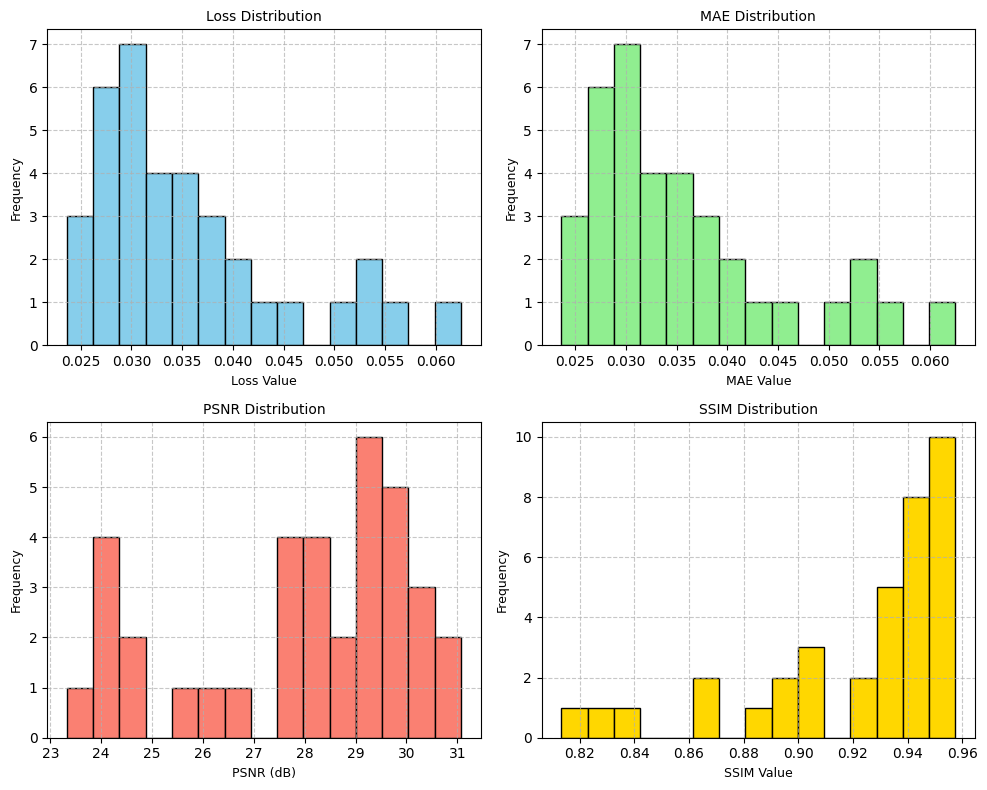

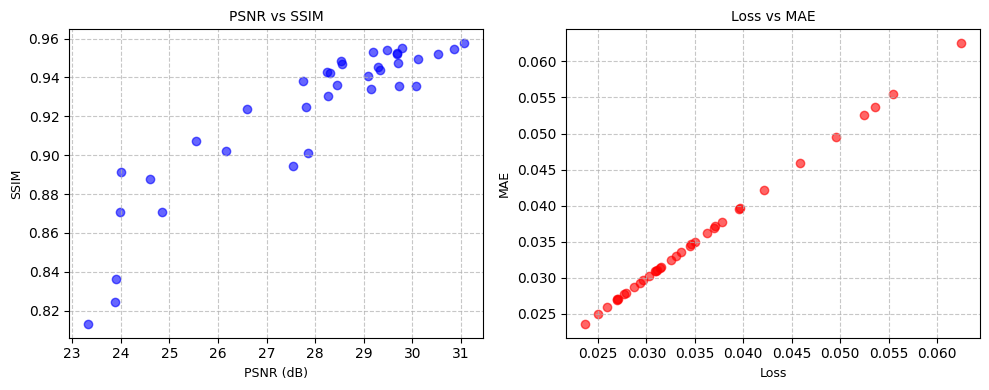


🖼️ Sample Output Comparison with Error Maps:


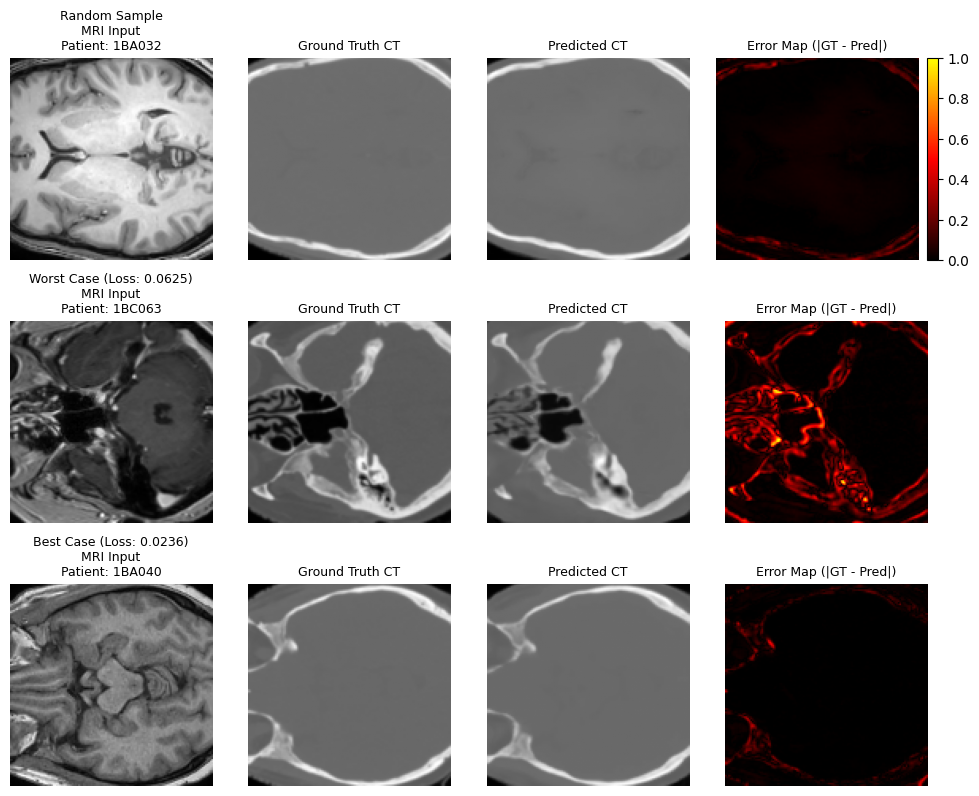

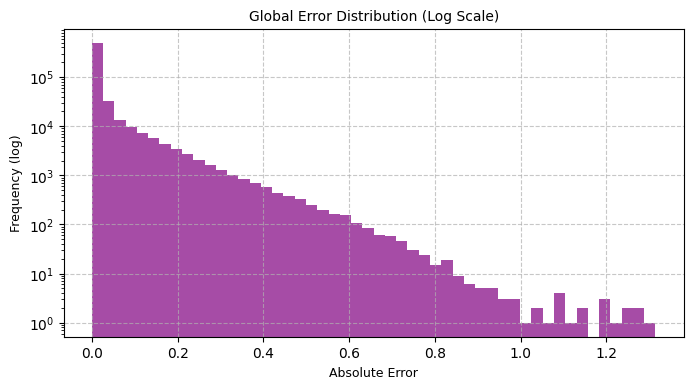


💾 Results saved to /content/drive/MyDrive/Colab Notebooks/brain/checkpoints_80_20_split_100epochs/test_results.csv


In [ ]:

################################ TESTING WITH ANALYSIS AND HISTOGRAMS AND EXAMPLES OF THE GENERATED CT FOR THE BEST AND THE WORSE CASES AND RANDOM CASE #####

model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "best_model.pt")))
model.eval()


patient_results = []
all_outputs = []
all_targets = []
all_slices = []

with torch.no_grad():
    for i, (mri, ct) in enumerate(test_loader):
        mri, ct = mri.to(device), ct.to(device)
        output = model(mri)

        # Store outputs and targets for analysis mb3d
        all_outputs.append(output.cpu())
        all_targets.append(ct.cpu())


        loss = criterion(output, ct).item()
        mae = F.l1_loss(output, ct).item()

        output_np = output[0].cpu().numpy()
        ct_np = ct[0].cpu().numpy()

        # Store middle slice for visualization
        slice_idx = output_np.shape[2] // 2
        all_slices.append({
            'mri': mri[0,0,:,:,slice_idx].cpu().numpy(),
            'ct': ct_np[0,:,:,slice_idx],
            'pred': output_np[0,:,:,slice_idx],
            'error': np.abs(ct_np[0,:,:,slice_idx] - output_np[0,:,:,slice_idx])
        })

        # Normalize for metrics
        output_np = np.clip((output_np + 1) / 2, 0, 1)
        ct_np = np.clip((ct_np + 1) / 2, 0, 1)

        psnr = peak_signal_noise_ratio(ct_np, output_np, data_range=1)
        ssim = structural_similarity(ct_np.squeeze(), output_np.squeeze(), data_range=1)

        # patient info
        original_idx = test_dataset.indices[i]
        patient_id = os.path.basename(dataset.patient_dirs[original_idx])

        patient_results.append({
            'Patient ID': patient_id,
            'Loss': loss,
            'MAE': mae,
            'PSNR': psnr,
            'SSIM': ssim,
            'Slice': slice_idx
        })





metrics = ['Loss', 'MAE', 'PSNR', 'SSIM']
stats = {m: {'values': [], 'mean': 0, 'std': 0} for m in metrics} # Calculate statistics

for res in patient_results:
    for m in metrics:
        stats[m]['values'].append(res[m])

for m in metrics:
    stats[m]['mean'] = np.mean(stats[m]['values'])
    stats[m]['std'] = np.std(stats[m]['values'])

# results
print("\n📊 Detailed Test Results Per Patient:")
print("{:<15} {:<10} {:<10} {:<12} {:<10}".format(
    "Patient ID", "Loss", "MAE", "PSNR (dB)", "SSIM"))
print("-" * 65)

for res in patient_results:
    print("{:<15} {:<10.4f} {:<10.4f} {:<12.2f} {:<10.4f}".format(
        res['Patient ID'], res['Loss'], res['MAE'], res['PSNR'], res['SSIM']))

print("-" * 65)
print("{:<15} {:<10.4f}±{:<8.4f} {:<10.4f}±{:<8.4f} {:<12.2f}±{:<8.2f} {:<10.4f}±{:<8.4f}".format(
    "Average",
    stats['Loss']['mean'], stats['Loss']['std'],
    stats['MAE']['mean'], stats['MAE']['std'],
    stats['PSNR']['mean'], stats['PSNR']['std'],
    stats['SSIM']['mean'], stats['SSIM']['std']
))


#  ANALYSIS

print("\n🔍 Performance Analysis:")
print(f"1. Worst Case (Highest Loss): {max(stats['Loss']['values']):.4f}")
print(f"   Patient: {patient_results[np.argmax(stats['Loss']['values'])]['Patient ID']}")
print(f"2. Best Case (Lowest Loss): {min(stats['Loss']['values']):.4f}")
print(f"   Patient: {patient_results[np.argmin(stats['Loss']['values'])]['Patient ID']}")
print(f"3. PSNR Range: {min(stats['PSNR']['values']):.2f} dB to {max(stats['PSNR']['values']):.2f} dB")
print(f"4. SSIM Consistency: {stats['SSIM']['std']/stats['SSIM']['mean']*100:.1f}% relative std")


# VISUALIZATION

try:
    import matplotlib.pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap

    #  for error visualization
    error_cmap = LinearSegmentedColormap.from_list('error_cmap', ['black', 'red', 'yellow'])

    # ====== Compact Histograms ======
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))


    axs[0, 0].hist(stats['Loss']['values'], bins=15, color='skyblue', edgecolor='black')
    axs[0, 0].set_title('Loss Distribution', fontsize=10)
    axs[0, 0].set_xlabel('Loss Value', fontsize=9)
    axs[0, 0].set_ylabel('Frequency', fontsize=9)
    axs[0, 0].grid(True, linestyle='--', alpha=0.7)


    axs[0, 1].hist(stats['MAE']['values'], bins=15, color='lightgreen', edgecolor='black')
    axs[0, 1].set_title('MAE Distribution', fontsize=10)
    axs[0, 1].set_xlabel('MAE Value', fontsize=9)
    axs[0, 1].set_ylabel('Frequency', fontsize=9)
    axs[0, 1].grid(True, linestyle='--', alpha=0.7)


    axs[1, 0].hist(stats['PSNR']['values'], bins=15, color='salmon', edgecolor='black')
    axs[1, 0].set_title('PSNR Distribution', fontsize=10)
    axs[1, 0].set_xlabel('PSNR (dB)', fontsize=9)
    axs[1, 0].set_ylabel('Frequency', fontsize=9)
    axs[1, 0].grid(True, linestyle='--', alpha=0.7)


    axs[1, 1].hist(stats['SSIM']['values'], bins=15, color='gold', edgecolor='black')
    axs[1, 1].set_title('SSIM Distribution', fontsize=10)
    axs[1, 1].set_xlabel('SSIM Value', fontsize=9)
    axs[1, 1].set_ylabel('Frequency', fontsize=9)
    axs[1, 1].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # ====== Metrics Correlation ======
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # PSNR vs SSIM # Loss vs MAE
    psnr_vals = [res['PSNR'] for res in patient_results]
    ssim_vals = [res['SSIM'] for res in patient_results]
    axs[0].scatter(psnr_vals, ssim_vals, c='blue', alpha=0.6)
    axs[0].set_title('PSNR vs SSIM', fontsize=10)
    axs[0].set_xlabel('PSNR (dB)', fontsize=9)
    axs[0].set_ylabel('SSIM', fontsize=9)
    axs[0].grid(True, linestyle='--', alpha=0.7)


    loss_vals = [res['Loss'] for res in patient_results]
    mae_vals = [res['MAE'] for res in patient_results]
    axs[1].scatter(loss_vals, mae_vals, c='red', alpha=0.6)
    axs[1].set_title('Loss vs MAE', fontsize=10)
    axs[1].set_xlabel('Loss', fontsize=9)
    axs[1].set_ylabel('MAE', fontsize=9)
    axs[1].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # ====== Sample Visualization ======
    print("\n🖼️ Sample Output Comparison with Error Maps:")

    # worst and best cases min howa best ofc
    worst_idx = np.argmax(stats['Loss']['values'])
    best_idx = np.argmin(stats['Loss']['values'])


    fig, axs = plt.subplots(3, 4, figsize=(10, 8))

    #cases to visualize
    cases = [
        ('Random Sample', 0),
        (f'Worst Case (Loss: {stats["Loss"]["values"][worst_idx]:.4f})', worst_idx),
        (f'Best Case (Loss: {stats["Loss"]["values"][best_idx]:.4f})', best_idx)
    ]

    for row, (title, idx) in enumerate(cases):
        data = all_slices[idx]
        patient_id = patient_results[idx]['Patient ID']


        axs[row, 0].imshow(data['mri'], cmap='gray')
        axs[row, 0].set_title(f"{title}\nMRI Input\nPatient: {patient_id}", fontsize=9)
        axs[row, 0].axis('off')


        axs[row, 1].imshow(data['ct'], cmap='gray')
        axs[row, 1].set_title("Ground Truth CT", fontsize=9)
        axs[row, 1].axis('off')


        axs[row, 2].imshow(data['pred'], cmap='gray')
        axs[row, 2].set_title("Predicted CT", fontsize=9)
        axs[row, 2].axis('off')


        error_img = axs[row, 3].imshow(data['error'], cmap=error_cmap, vmin=0, vmax=1.0)
        axs[row, 3].set_title("Error Map (|GT - Pred|)", fontsize=9)
        axs[row, 3].axis('off')

        #colorbar
        if row == 0:
            fig.colorbar(error_img, ax=axs[row, 3], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    plt.show()

    # ====== Error Distribution Analysis ======
    all_errors = []
    for data in all_slices:
        all_errors.extend(data['error'].flatten())

    plt.figure(figsize=(8, 4))
    plt.hist(all_errors, bins=50, color='purple', alpha=0.7, log=True)
    plt.title('Global Error Distribution (Log Scale)', fontsize=10)
    plt.xlabel('Absolute Error', fontsize=9)
    plt.ylabel('Frequency (log)', fontsize=9)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

except ImportError:
    print("⚠️ matplotlib not available - skipping visualizations")

# ====================== SAVE RESULTS TO FILE ===========================

results_file = os.path.join(checkpoint_dir, "test_results.csv")
with open(results_file, 'w') as f:
    f.write("Patient ID,Loss,MAE,PSNR,SSIM\n")
    for res in patient_results:
        f.write(f"{res['Patient ID']},{res['Loss']:.4f},{res['MAE']:.4f},{res['PSNR']:.2f},{res['SSIM']:.4f}\n")
print(f"\n💾 Results saved to {results_file}")

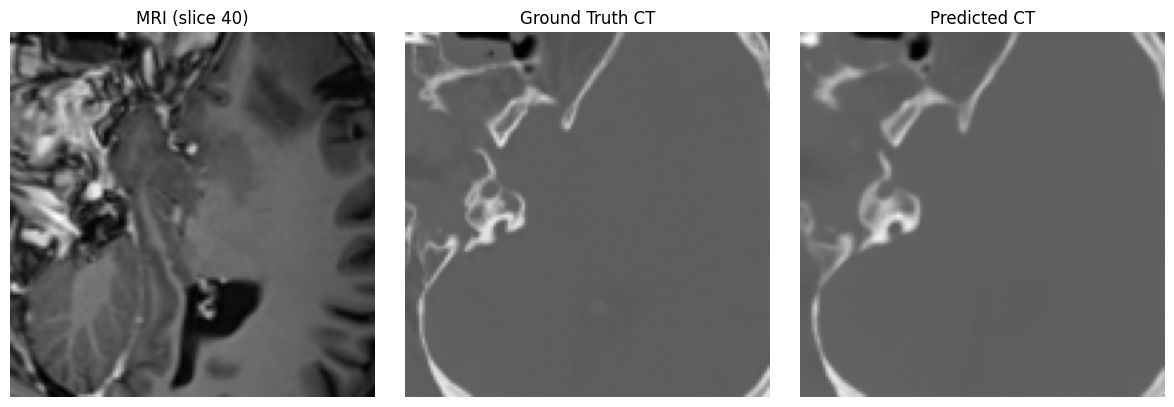

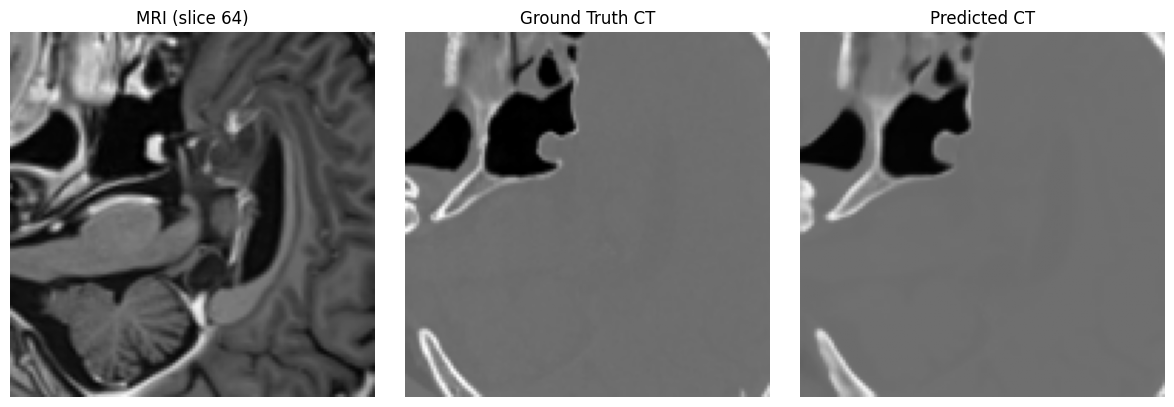

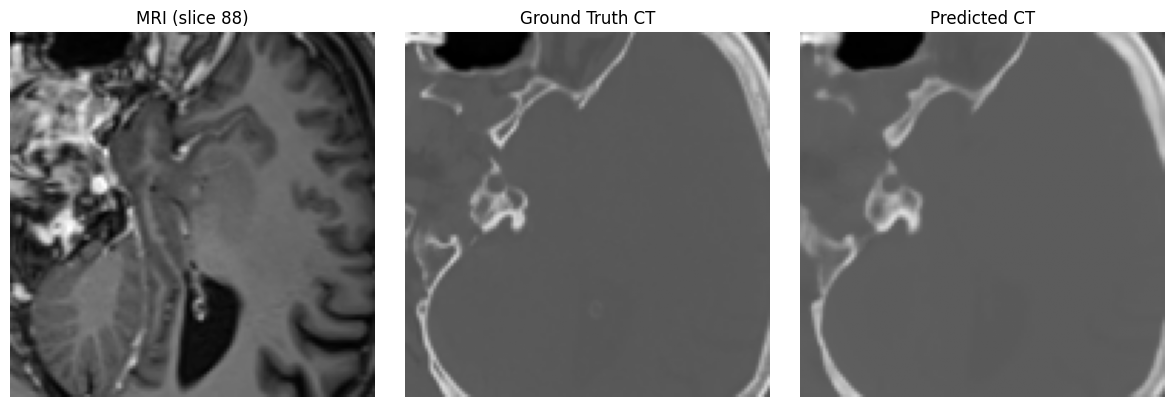

In [ ]:
########################### Show Slice Comparison EX : 40, 64, 88 ####################
import matplotlib.pyplot as plt

# Nbr slices
slice_indices = [40, 64, 88]

# Denormalize
mri = (mri + 1) / 2
ct = (ct + 1) / 2
pred_ct = (pred_ct + 1) / 2

# Convert arrays
mri_np = mri[0, 0].cpu().numpy()
ct_np = ct[0, 0].cpu().numpy()
pred_np = pred_ct[0, 0].cpu().numpy()

for idx in slice_indices:
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(mri_np[idx], cmap="gray")
    axs[0].set_title(f"MRI (slice {idx})")
    axs[0].axis("off")

    axs[1].imshow(ct_np[idx], cmap="gray")
    axs[1].set_title("Ground Truth CT")
    axs[1].axis("off")

    axs[2].imshow(pred_np[idx], cmap="gray")
    axs[2].set_title("Predicted CT")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:

####################################### View Training Progress Results: Loss, MAE, PSNR, and SSIM Over Time ################################
# # Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
# # ✨ Starting new training
# # Epoch 1: 100%
# #  144/144 [04:58<00:00,  2.07s/it]
# # Epoch 1 | Loss=0.1465 | MAE=0.1465 | PSNR=18.48 | SSIM=0.5448
# # ✅ Saved best model (loss: 0.1465)
# # Epoch 2: 100%
# #  144/144 [05:03<00:00,  2.18s/it]
# # Epoch 2 | Loss=0.0935 | MAE=0.0935 | PSNR=20.86 | SSIM=0.7011
# # ✅ Saved best model (loss: 0.0935)
# # Epoch 3: 100%
# #  144/144 [05:07<00:00,  2.14s/it]
# # Epoch 3 | Loss=0.0848 | MAE=0.0848 | PSNR=21.53 | SSIM=0.7333
# # ✅ Saved best model (loss: 0.0848)
# # Epoch 4: 100%
# #  144/144 [05:07<00:00,  2.10s/it]
# # Epoch 4 | Loss=0.0781 | MAE=0.0781 | PSNR=22.05 | SSIM=0.7567
# # ✅ Saved best model (loss: 0.0781)
# # Epoch 5: 100%
# #  144/144 [05:07<00:00,  2.06s/it]
# # Epoch 5 | Loss=0.0730 | MAE=0.0730 | PSNR=22.48 | SSIM=0.7746
# # ✅ Saved best model (loss: 0.0730)
# # Epoch 6: 100%
# #  144/144 [05:07<00:00,  2.19s/it]
# # Epoch 6 | Loss=0.0710 | MAE=0.0710 | PSNR=22.68 | SSIM=0.7855
# # ✅ Saved best model (loss: 0.0710)
# # Epoch 7: 100%
# #  144/144 [05:08<00:00,  2.10s/it]
# # Epoch 7 | Loss=0.0672 | MAE=0.0672 | PSNR=22.98 | SSIM=0.7971
# # ✅ Saved best model (loss: 0.0672)
# # Epoch 8: 100%
# #  144/144 [05:09<00:00,  2.16s/it]
# # Epoch 8 | Loss=0.0636 | MAE=0.0636 | PSNR=23.35 | SSIM=0.8114
# # ✅ Saved best model (loss: 0.0636)
# # Epoch 9: 100%
# #  144/144 [05:08<00:00,  2.13s/it]
# # Epoch 9 | Loss=0.0617 | MAE=0.0617 | PSNR=23.55 | SSIM=0.8203
# # ✅ Saved best model (loss: 0.0617)
# # Epoch 10: 100%
# #  144/144 [05:08<00:00,  2.12s/it]
# # Epoch 10 | Loss=0.0597 | MAE=0.0597 | PSNR=23.73 | SSIM=0.8274
# # ✅ Saved best model (loss: 0.0597)
# # Epoch 11: 100%
# #  144/144 [05:07<00:00,  2.12s/it]
# # Epoch 11 | Loss=0.0580 | MAE=0.0580 | PSNR=23.92 | SSIM=0.8346
# # ✅ Saved best model (loss: 0.0580)
# # Epoch 12: 100%
# #  144/144 [05:07<00:00,  2.18s/it]
# # Epoch 12 | Loss=0.0574 | MAE=0.0574 | PSNR=24.01 | SSIM=0.8376
# # ✅ Saved best model (loss: 0.0574)
# # Epoch 13: 100%
# #  144/144 [05:09<00:00,  2.10s/it]
# # Epoch 13 | Loss=0.0562 | MAE=0.0562 | PSNR=24.19 | SSIM=0.8436
# # ✅ Saved best model (loss: 0.0562)
# # Epoch 14: 100%
# #  144/144 [05:13<00:00,  2.28s/it]
# # Epoch 14 | Loss=0.0546 | MAE=0.0546 | PSNR=24.30 | SSIM=0.8483
# # ✅ Saved best model (loss: 0.0546)
# # Epoch 15: 100%
# #  144/144 [05:08<00:00,  2.12s/it]
# # Epoch 15 | Loss=0.0533 | MAE=0.0533 | PSNR=24.48 | SSIM=0.8535
# # ✅ Saved best model (loss: 0.0533)
# # Epoch 16: 100%
# #  144/144 [05:08<00:00,  2.10s/it]
# # Epoch 16 | Loss=0.0531 | MAE=0.0531 | PSNR=24.48 | SSIM=0.8548
# # ✅ Saved best model (loss: 0.0531)
# # Epoch 17: 100%
# #  144/144 [05:13<00:00,  2.16s/it]
# # Epoch 17 | Loss=0.0512 | MAE=0.0512 | PSNR=24.71 | SSIM=0.8607
# # ✅ Saved best model (loss: 0.0512)
# # Epoch 18: 100%
# #  144/144 [05:16<00:00,  2.18s/it]
# # Epoch 18 | Loss=0.0512 | MAE=0.0512 | PSNR=24.79 | SSIM=0.8624
# # ✅ Saved best model (loss: 0.0512)
# # Epoch 19: 100%
# #  144/144 [05:18<00:00,  2.17s/it]
# # Epoch 19 | Loss=0.0508 | MAE=0.0508 | PSNR=24.77 | SSIM=0.8626
# # ✅ Saved best model (loss: 0.0508)
# # Epoch 20: 100%
# #  144/144 [05:08<00:00,  2.18s/it]
# # Epoch 20 | Loss=0.0501 | MAE=0.0501 | PSNR=24.89 | SSIM=0.8675
# # ✅ Saved best model (loss: 0.0501)
# # Epoch 21: 100%
# #  144/144 [05:09<00:00,  2.28s/it]
# # Epoch 21 | Loss=0.0496 | MAE=0.0496 | PSNR=24.99 | SSIM=0.8684
# # ✅ Saved best model (loss: 0.0496)
# # Epoch 22: 100%
# #  144/144 [05:11<00:00,  2.25s/it]
# # Epoch 22 | Loss=0.0486 | MAE=0.0486 | PSNR=25.11 | SSIM=0.8708
# # ✅ Saved best model (loss: 0.0486)
# # Epoch 23: 100%
# #  144/144 [05:19<00:00,  2.23s/it]
# # Epoch 23 | Loss=0.0481 | MAE=0.0481 | PSNR=25.20 | SSIM=0.8729
# # ✅ Saved best model (loss: 0.0481)
# # Epoch 24: 100%
# #  144/144 [05:19<00:00,  2.18s/it]
# # Epoch 24 | Loss=0.0473 | MAE=0.0473 | PSNR=25.24 | SSIM=0.8766
# # ✅ Saved best model (loss: 0.0473)
# # Epoch 25: 100%
# #  144/144 [05:10<00:00,  2.26s/it]
# # Epoch 25 | Loss=0.0470 | MAE=0.0470 | PSNR=25.31 | SSIM=0.8771
# # ✅ Saved best model (loss: 0.0470)
# # Epoch 26: 100%
# #  144/144 [05:09<00:00,  2.21s/it]
# # Epoch 26 | Loss=0.0471 | MAE=0.0471 | PSNR=25.36 | SSIM=0.8784
# # Epoch 27: 100%
# #  144/144 [05:12<00:00,  2.12s/it]
# # Epoch 27 | Loss=0.0458 | MAE=0.0458 | PSNR=25.52 | SSIM=0.8812
# # ✅ Saved best model (loss: 0.0458)
# # Epoch 28: 100%
# #  144/144 [05:14<00:00,  2.27s/it]
# # Epoch 28 | Loss=0.0456 | MAE=0.0456 | PSNR=25.53 | SSIM=0.8819
# # ✅ Saved best model (loss: 0.0456)
# # Epoch 29: 100%
# #  144/144 [05:16<00:00,  2.13s/it]
# # Epoch 29 | Loss=0.0453 | MAE=0.0453 | PSNR=25.62 | SSIM=0.8831
# # ✅ Saved best model (loss: 0.0453)
# # Epoch 30: 100%
# #  144/144 [05:09<00:00,  2.08s/it]
# # Epoch 30 | Loss=0.0451 | MAE=0.0451 | PSNR=25.66 | SSIM=0.8840
# # ✅ Saved best model (loss: 0.0451)
# # Epoch 31: 100%
# #  144/144 [05:07<00:00,  2.18s/it]
# # Epoch 31 | Loss=0.0446 | MAE=0.0446 | PSNR=25.75 | SSIM=0.8860
# # ✅ Saved best model (loss: 0.0446)
# # Epoch 32: 100%
# #  144/144 [05:08<00:00,  2.07s/it]
# # Epoch 32 | Loss=0.0439 | MAE=0.0439 | PSNR=25.83 | SSIM=0.8882
# # ✅ Saved best model (loss: 0.0439)
# # Epoch 33: 100%
# #  144/144 [05:08<00:00,  2.17s/it]
# # Epoch 33 | Loss=0.0435 | MAE=0.0435 | PSNR=25.90 | SSIM=0.8891
# # ✅ Saved best model (loss: 0.0435)
# # Epoch 34: 100%
# #  144/144 [05:07<00:00,  2.10s/it]
# # Epoch 34 | Loss=0.0437 | MAE=0.0437 | PSNR=25.87 | SSIM=0.8887
# # Epoch 35: 100%
# #  144/144 [05:07<00:00,  2.14s/it]
# # Epoch 35 | Loss=0.0423 | MAE=0.0423 | PSNR=26.15 | SSIM=0.8936
# # ✅ Saved best model (loss: 0.0423)
# # Epoch 36: 100%
# #  144/144 [05:07<00:00,  2.19s/it]
# # Epoch 36 | Loss=0.0420 | MAE=0.0420 | PSNR=26.25 | SSIM=0.8944
# # ✅ Saved best model (loss: 0.0420)
# # Epoch 37: 100%
# #  144/144 [05:09<00:00,  2.19s/it]
# # Epoch 37 | Loss=0.0418 | MAE=0.0418 | PSNR=26.36 | SSIM=0.8959
# # ✅ Saved best model (loss: 0.0418)
# # Epoch 38: 100%
# #  144/144 [05:07<00:00,  2.20s/it]
# # Epoch 38 | Loss=0.0405 | MAE=0.0405 | PSNR=26.53 | SSIM=0.8996
# # ✅ Saved best model (loss: 0.0405)
# # Epoch 39: 100%
# #  144/144 [05:10<00:00,  2.16s/it]
# # Epoch 39 | Loss=0.0402 | MAE=0.0402 | PSNR=26.60 | SSIM=0.9011
# # ✅ Saved best model (loss: 0.0402)
# # Epoch 40: 100%
# #  144/144 [05:10<00:00,  2.15s/it]
# # Epoch 40 | Loss=0.0400 | MAE=0.0400 | PSNR=26.67 | SSIM=0.9023
# # ✅ Saved best model (loss: 0.0400)
# # Epoch 41: 100%
# #  144/144 [05:08<00:00,  2.19s/it]
# # Epoch 41 | Loss=0.0400 | MAE=0.0400 | PSNR=26.67 | SSIM=0.9013
# # Epoch 42: 100%
# #  144/144 [05:08<00:00,  2.21s/it]
# # Epoch 42 | Loss=0.0404 | MAE=0.0404 | PSNR=26.64 | SSIM=0.9003
# # Epoch 43: 100%
# #  144/144 [05:07<00:00,  2.10s/it]
# # Epoch 43 | Loss=0.0404 | MAE=0.0404 | PSNR=26.57 | SSIM=0.9000
# # Epoch 44: 100%
# #  144/144 [05:08<00:00,  2.06s/it]
# # Epoch 44 | Loss=0.0400 | MAE=0.0400 | PSNR=26.68 | SSIM=0.9013
# # Epoch 45: 100%
# #  144/144 [05:08<00:00,  2.15s/it]
# # Epoch 45 | Loss=0.0399 | MAE=0.0399 | PSNR=26.65 | SSIM=0.9027
# # ✅ Saved best model (loss: 0.0399)
# # Epoch 46: 100%
# #  144/144 [05:08<00:00,  2.17s/it]
# # Epoch 46 | Loss=0.0389 | MAE=0.0389 | PSNR=26.91 | SSIM=0.9051
# # ✅ Saved best model (loss: 0.0389)
# # Epoch 47: 100%
# #  144/144 [05:09<00:00,  2.06s/it]
# # Epoch 47 | Loss=0.0381 | MAE=0.0381 | PSNR=27.04 | SSIM=0.9077
# # ✅ Saved best model (loss: 0.0381)
# # Epoch 48: 100%
# #  144/144 [05:08<00:00,  2.12s/it]
# # Epoch 48 | Loss=0.0378 | MAE=0.0378 | PSNR=27.14 | SSIM=0.9089
# # ✅ Saved best model (loss: 0.0378)
# # Epoch 49: 100%
# #  144/144 [05:09<00:00,  2.12s/it]
# # Epoch 49 | Loss=0.0378 | MAE=0.0378 | PSNR=27.14 | SSIM=0.9094
# # ✅ Saved best model (loss: 0.0378)
# # Epoch 50: 100%
# #  144/144 [05:08<00:00,  2.12s/it]
# # Epoch 50 | Loss=0.0376 | MAE=0.0376 | PSNR=27.20 | SSIM=0.9105
# # ✅ Saved best model (loss: 0.0376)

# # 📊 Test Results:
# # Test Loss:  0.0466
# # Test MAE:   0.0466
# # Test PSNR:  24.98
# # Test SSIM:  0.8819

# # Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
# # ✅ Resumed training from epoch 51 (best val loss: 0.0378)
# # Epoch 52: 100%
# #  144/144 [05:08<00:00,  2.14s/it]
# # Epoch 52 | Loss=0.0392 | MAE=0.0392 | PSNR=26.74 | SSIM=0.9045
# # Epoch 53: 100%
# #  144/144 [05:09<00:00,  2.13s/it]
# # Epoch 53 | Loss=0.0391 | MAE=0.0391 | PSNR=26.74 | SSIM=0.9051
# # Epoch 54: 100%
# #  144/144 [05:09<00:00,  2.13s/it]
# # Epoch 54 | Loss=0.0380 | MAE=0.0380 | PSNR=27.01 | SSIM=0.9084
# # Epoch 55: 100%
# #  144/144 [05:09<00:00,  2.19s/it]
# # Epoch 55 | Loss=0.0374 | MAE=0.0374 | PSNR=27.13 | SSIM=0.9108
# # ✅ Saved best model (loss: 0.0374)
# # Epoch 56: 100%
# #  144/144 [05:11<00:00,  2.17s/it]
# # Epoch 56 | Loss=0.0389 | MAE=0.0389 | PSNR=26.72 | SSIM=0.9060
# # Epoch 57: 100%
# #  144/144 [05:09<00:00,  2.15s/it]
# # Epoch 57 | Loss=0.0374 | MAE=0.0374 | PSNR=27.17 | SSIM=0.9103
# # Epoch 58: 100%
# #  144/144 [05:10<00:00,  2.21s/it]
# # Epoch 58 | Loss=0.0361 | MAE=0.0361 | PSNR=27.40 | SSIM=0.9151
# # ✅ Saved best model (loss: 0.0361)
# # Epoch 59: 100%
# #  144/144 [05:14<00:00,  2.24s/it]
# # Epoch 59 | Loss=0.0362 | MAE=0.0362 | PSNR=27.46 | SSIM=0.9146
# # Epoch 60: 100%
# #  144/144 [05:13<00:00,  2.16s/it]
# # Epoch 60 | Loss=0.0358 | MAE=0.0358 | PSNR=27.54 | SSIM=0.9154
# # ✅ Saved best model (loss: 0.0358)
# # Epoch 61: 100%
# #  144/144 [05:14<00:00,  2.14s/it]
# # Epoch 61 | Loss=0.0354 | MAE=0.0354 | PSNR=27.62 | SSIM=0.9176
# # ✅ Saved best model (loss: 0.0354)
# # Epoch 62: 100%
# #  144/144 [05:14<00:00,  2.15s/it]
# # Epoch 62 | Loss=0.0350 | MAE=0.0350 | PSNR=27.71 | SSIM=0.9184
# # ✅ Saved best model (loss: 0.0350)
# # Epoch 63: 100%
# #  144/144 [05:14<00:00,  2.27s/it]
# # Epoch 63 | Loss=0.0348 | MAE=0.0348 | PSNR=27.74 | SSIM=0.9194
# # ✅ Saved best model (loss: 0.0348)
# # Epoch 64: 100%
# #  144/144 [05:16<00:00,  2.12s/it]
# # Epoch 64 | Loss=0.0351 | MAE=0.0351 | PSNR=27.73 | SSIM=0.9189
# # Epoch 65: 100%
# #  144/144 [05:14<00:00,  2.19s/it]
# # Epoch 65 | Loss=0.0349 | MAE=0.0349 | PSNR=27.78 | SSIM=0.9189
# # Epoch 66: 100%
# #  144/144 [05:14<00:00,  2.14s/it]
# # Epoch 66 | Loss=0.0341 | MAE=0.0341 | PSNR=27.91 | SSIM=0.9208
# # ✅ Saved best model (loss: 0.0341)
# # Epoch 67: 100%
# #  144/144 [05:15<00:00,  2.11s/it]
# # Epoch 67 | Loss=0.0342 | MAE=0.0342 | PSNR=27.93 | SSIM=0.9217
# # Epoch 68: 100%
# #  144/144 [05:14<00:00,  2.12s/it]
# # Epoch 68 | Loss=0.0340 | MAE=0.0340 | PSNR=27.95 | SSIM=0.9225
# # ✅ Saved best model (loss: 0.0340)
# # Epoch 69: 100%
# #  144/144 [05:16<00:00,  2.25s/it]
# # Epoch 69 | Loss=0.0336 | MAE=0.0336 | PSNR=28.06 | SSIM=0.9231
# # ✅ Saved best model (loss: 0.0336)
# # Epoch 70: 100%
# #  144/144 [05:20<00:00,  2.23s/it]
# # Epoch 70 | Loss=0.0333 | MAE=0.0333 | PSNR=28.12 | SSIM=0.9244
# # ✅ Saved best model (loss: 0.0333)
# # Epoch 71: 100%
# #  144/144 [05:21<00:00,  2.22s/it]
# # Epoch 71 | Loss=0.0332 | MAE=0.0332 | PSNR=28.15 | SSIM=0.9251
# # ✅ Saved best model (loss: 0.0332)
# # Epoch 72: 100%
# #  144/144 [05:23<00:00,  2.33s/it]
# # Epoch 72 | Loss=0.0331 | MAE=0.0331 | PSNR=28.21 | SSIM=0.9249
# # ✅ Saved best model (loss: 0.0331)
# # Epoch 73: 100%
# #  144/144 [05:22<00:00,  2.33s/it]
# # Epoch 73 | Loss=0.0330 | MAE=0.0330 | PSNR=28.20 | SSIM=0.9259
# # ✅ Saved best model (loss: 0.0330)
# # Epoch 74: 100%
# #  144/144 [05:18<00:00,  2.16s/it]
# # Epoch 74 | Loss=0.0327 | MAE=0.0327 | PSNR=28.30 | SSIM=0.9257
# # ✅ Saved best model (loss: 0.0327)
# # Epoch 75: 100%
# #  144/144 [05:19<00:00,  2.24s/it]
# # Epoch 75 | Loss=0.0324 | MAE=0.0324 | PSNR=28.32 | SSIM=0.9272
# # ✅ Saved best model (loss: 0.0324)
# # Epoch 76: 100%
# #  144/144 [05:20<00:00,  2.23s/it]
# # Epoch 76 | Loss=0.0325 | MAE=0.0325 | PSNR=28.35 | SSIM=0.9277
# # Epoch 77: 100%
# #  144/144 [05:17<00:00,  2.23s/it]
# # Epoch 77 | Loss=0.0321 | MAE=0.0321 | PSNR=28.47 | SSIM=0.9283
# # ✅ Saved best model (loss: 0.0321)
# # Epoch 78: 100%
# #  144/144 [05:18<00:00,  2.30s/it]
# # Epoch 78 | Loss=0.0319 | MAE=0.0319 | PSNR=28.49 | SSIM=0.9291
# # ✅ Saved best model (loss: 0.0319)
# # Epoch 79: 100%
# #  144/144 [05:20<00:00,  2.32s/it]
# # Epoch 79 | Loss=0.0315 | MAE=0.0315 | PSNR=28.59 | SSIM=0.9302
# # ✅ Saved best model (loss: 0.0315)
# # Epoch 80: 100%
# #  144/144 [05:22<00:00,  2.21s/it]
# # Epoch 80 | Loss=0.0314 | MAE=0.0314 | PSNR=28.63 | SSIM=0.9305
# # ✅ Saved best model (loss: 0.0314)

# # 📊 Test Results:
# # Test Loss:  0.0421
# # Test MAE:   0.0421
# # Test PSNR:  25.91
# # Test SSIM:  0.8968

# # Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
# # ✅ Resumed training from epoch 80 (best val loss: 0.0315)
# # Epoch 81: 100%
# #  144/144 [04:58<00:00,  2.06s/it]
# # Epoch 81 | Loss=0.0350 | MAE=0.0350 | PSNR=27.63 | SSIM=0.9204
# # Epoch 82: 100%
# #  144/144 [05:00<00:00,  2.02s/it]
# # Epoch 82 | Loss=0.0335 | MAE=0.0335 | PSNR=28.02 | SSIM=0.9253
# # Epoch 83: 100%
# #  144/144 [04:58<00:00,  2.11s/it]
# # Epoch 83 | Loss=0.0328 | MAE=0.0328 | PSNR=28.27 | SSIM=0.9270
# # Epoch 84: 100%
# #  144/144 [04:59<00:00,  2.05s/it]
# # Epoch 84 | Loss=0.0320 | MAE=0.0320 | PSNR=28.41 | SSIM=0.9299
# # Epoch 85: 100%
# #  144/144 [04:59<00:00,  2.10s/it]
# # Epoch 85 | Loss=0.0319 | MAE=0.0319 | PSNR=28.45 | SSIM=0.9302
# # Epoch 86: 100%
# #  144/144 [04:59<00:00,  2.05s/it]
# # Epoch 86 | Loss=0.0316 | MAE=0.0316 | PSNR=28.56 | SSIM=0.9306
# # Epoch 87: 100%
# #  144/144 [04:59<00:00,  2.13s/it]
# # Epoch 87 | Loss=0.0314 | MAE=0.0314 | PSNR=28.56 | SSIM=0.9319
# # ✅ Saved best model (loss: 0.0314)
# # Epoch 88: 100%
# #  144/144 [04:59<00:00,  2.09s/it]
# # Epoch 88 | Loss=0.0311 | MAE=0.0311 | PSNR=28.67 | SSIM=0.9322
# # ✅ Saved best model (loss: 0.0311)
# # Epoch 89: 100%
# #  144/144 [05:01<00:00,  2.06s/it]
# # Epoch 89 | Loss=0.0301 | MAE=0.0301 | PSNR=28.85 | SSIM=0.9352
# # ✅ Saved best model (loss: 0.0301)
# # Epoch 90: 100%
# #  144/144 [05:01<00:00,  2.07s/it]
# # Epoch 90 | Loss=0.0300 | MAE=0.0300 | PSNR=28.95 | SSIM=0.9356
# # ✅ Saved best model (loss: 0.0300)
# # Epoch 91: 100%
# #  144/144 [04:59<00:00,  2.04s/it]
# # Epoch 91 | Loss=0.0304 | MAE=0.0304 | PSNR=28.87 | SSIM=0.9351
# # Epoch 92: 100%
# #  144/144 [04:59<00:00,  2.07s/it]
# # Epoch 92 | Loss=0.0303 | MAE=0.0303 | PSNR=28.89 | SSIM=0.9347
# # Epoch 93: 100%
# #  144/144 [04:59<00:00,  2.10s/it]
# # Epoch 93 | Loss=0.0300 | MAE=0.0300 | PSNR=28.97 | SSIM=0.9364
# # ✅ Saved best model (loss: 0.0300)
# # Epoch 94: 100%
# #  144/144 [05:01<00:00,  2.06s/it]
# # Epoch 94 | Loss=0.0302 | MAE=0.0302 | PSNR=28.98 | SSIM=0.9360
# # Epoch 95: 100%
# #  144/144 [05:01<00:00,  2.05s/it]
# # Epoch 95 | Loss=0.0296 | MAE=0.0296 | PSNR=29.05 | SSIM=0.9377
# # ✅ Saved best model (loss: 0.0296)
# # Epoch 96: 100%
# #  144/144 [05:02<00:00,  2.11s/it]
# # Epoch 96 | Loss=0.0295 | MAE=0.0295 | PSNR=29.10 | SSIM=0.9374
# # ✅ Saved best model (loss: 0.0295)
# # Epoch 97: 100%
# #  144/144 [05:00<00:00,  2.06s/it]
# # Epoch 97 | Loss=0.0298 | MAE=0.0298 | PSNR=29.07 | SSIM=0.9370
# # Epoch 98: 100%
# #  144/144 [05:02<00:00,  2.11s/it]
# # Epoch 98 | Loss=0.0294 | MAE=0.0294 | PSNR=29.16 | SSIM=0.9389
# # ✅ Saved best model (loss: 0.0294)
# # Epoch 99: 100%
# #  144/144 [05:01<00:00,  2.09s/it]
# # Epoch 99 | Loss=0.0288 | MAE=0.0288 | PSNR=29.27 | SSIM=0.9402
# # ✅ Saved best model (loss: 0.0288)


# Mounted at /content/drive
# ✅ Resumed training from epoch 99 (best val loss: 0.0235)
# Epoch 100: 100%
#  144/144 [16:31<00:00,  7.38s/it]
# Epoch 100 | Loss=0.0295 | MAE=0.0295 | PSNR=29.40 | SSIM=0.9402

# 📊 Test Results:
# Test Loss:  0.0319
# Test MAE:   0.0319
# Test PSNR:  28.75
# Test SSIM:  0.9312


In [ ]:
# !pip install -q monai
# !pip install numpy==1.24.4

In [ ]:
##############################################THE FIRST TRIED CODE WITH CROSS VALIDATION ############################################

# from google.colab import drive
# drive.mount('/content/drive')

# import nibabel as nib
# # import numpy as np
# # import matplotlib.pyplot as plt

# # # Replace with one of your actual patient folders
# # patient_folder = '/content/drive/MyDrive/Colab Notebooks/brain/1BA001/'

# # def load_nii(path):
# #     return nib.load(path).get_fdata().astype(np.float32)

# # mr = load_nii(patient_folder + 'mr.nii.gz')
# # ct = load_nii(patient_folder + 'ct.nii.gz')
# # mask = load_nii(patient_folder + 'mask.nii.gz')

# # print(f"Shapes — MR: {mr.shape}, CT: {ct.shape}, Mask: {mask.shape}")

# # # Visualize middle axial slice
# # slice_idx = mr.shape[2] // 2

# # plt.figure(figsize=(15,5))
# # plt.subplot(1,3,1)
# # plt.imshow(mr[:, :, slice_idx], cmap='gray')
# # plt.title('MRI - Axial Slice')
# # plt.axis('off')

# # plt.subplot(1,3,2)
# # plt.imshow(ct[:, :, slice_idx], cmap='gray')
# # plt.title('CT - Axial Slice')
# # plt.axis('off')

# # plt.subplot(1,3,3)
# # plt.imshow(mask[:, :, slice_idx], cmap='gray')
# # plt.title('Mask - Axial Slice')
# # plt.axis('off')

# # plt.show()

# # import numpy as np
# # import torch

# # def z_score_normalize(volume, mask):
# #     values = volume[mask > 0]
# #     mean = values.mean()
# #     std = values.std()
# #     normalized = (volume - mean) / (std + 1e-8)
# #     return normalized

# # def clip_and_scale_ct(ct, min_hu=-1000, max_hu=2000):
# #     ct = np.clip(ct, min_hu, max_hu)
# #     ct = 2 * (ct - min_hu) / (max_hu - min_hu) - 1  # scale to [-1, 1]
# #     return ct

# # def crop_center(volume, target_shape=(128,128,128)):
# #     current_shape = volume.shape
# #     start = [(c - t) // 2 for c, t in zip(current_shape, target_shape)]
# #     end = [start[i] + target_shape[i] for i in range(3)]
# #     cropped = volume[start[0]:end[0], start[1]:end[1], start[2]:end[2]]
# #     return cropped

# # # Example usage
# # mr_norm = z_score_normalize(mr, mask)
# # ct_norm = clip_and_scale_ct(ct)

# # target_shape = (128, 128, 128)
# # mr_crop = crop_center(mr_norm, target_shape)
# # ct_crop = crop_center(ct_norm, target_shape)
# # mask_crop = crop_center(mask, target_shape)

# # print(mr_crop.shape, ct_crop.shape, mask_crop.shape)



# import os
# import nibabel as nib
# import numpy as np
# import torch
# from torch.utils.data import Dataset

# class BrainMRICTDataset(Dataset):
#     def __init__(self, patient_dirs, target_shape=(128,128,128), device='cpu'):
#         self.patient_dirs = patient_dirs
#         self.target_shape = target_shape
#         self.device = device

#     def __len__(self):
#         return len(self.patient_dirs)

#     def load_nii(self, path):
#         return nib.load(path).get_fdata().astype(np.float32)

#     def z_score_normalize(self, volume, mask=None):
#         # If mask is provided, use masked mean/std; else use full volume
#         if mask is not None:
#             values = volume[mask > 0]
#             mean = values.mean()
#             std = values.std()
#         else:
#             mean = volume.mean()
#             std = volume.std()
#         return (volume - mean) / (std + 1e-8)

#     def clip_and_scale_ct(self, ct, min_hu=-1000, max_hu=2000):
#         ct = np.clip(ct, min_hu, max_hu)
#         ct = 2 * (ct - min_hu) / (max_hu - min_hu) - 1  # scale to [-1, 1]
#         return ct

#     def crop_center(self, volume):
#         current_shape = volume.shape
#         start = [(c - t) // 2 for c, t in zip(current_shape, self.target_shape)]
#         end = [start[i] + self.target_shape[i] for i in range(3)]
#         return volume[start[0]:end[0], start[1]:end[1], start[2]:end[2]]

#     def __getitem__(self, idx):
#         patient_dir = self.patient_dirs[idx]

#         mr = self.load_nii(os.path.join(patient_dir, 'mr.nii.gz'))
#         ct = self.load_nii(os.path.join(patient_dir, 'ct.nii.gz'))

#         # Normalize MR and CT (without mask)
#         mr = self.z_score_normalize(mr, mask=None)
#         ct = self.clip_and_scale_ct(ct)

#         # Crop to target shape
#         mr = self.crop_center(mr)
#         ct = self.crop_center(ct)

#         # Convert to tensors and add channel dim (1, D, H, W)
#         mr_tensor = torch.tensor(mr, dtype=torch.float32).unsqueeze(0)
#         ct_tensor = torch.tensor(ct, dtype=torch.float32).unsqueeze(0)

#         return mr_tensor.to(self.device), ct_tensor.to(self.device)


# from glob import glob

# patient_paths = sorted(glob('/content/drive/MyDrive/Colab Notebooks/brain/*'))

# dataset = BrainMRICTDataset(patient_paths, target_shape=(128,128,128), device='cuda' if torch.cuda.is_available() else 'cpu')

# print(f"Dataset size: {len(dataset)}")

# mr, ct = dataset[0]

# print(mr.shape, ct.shape)  # should all be (1, 128, 128, 128)





# import torch
# import torch.nn as nn

# class UNet3D(nn.Module):
#     def __init__(self, in_channels=1, out_channels=1, features=[32, 64, 128, 256]):
#         super().__init__()
#         self.encoder = nn.ModuleList()
#         self.decoder = nn.ModuleList()

#         for feature in features:
#             self.encoder.append(self._block(in_channels, feature))
#             in_channels = feature

#         for feature in reversed(features):
#             self.decoder.append(nn.ConvTranspose3d(feature*2, feature, kernel_size=2, stride=2))
#             self.decoder.append(self._block(feature*2, feature))

#         self.bottleneck = self._block(features[-1], features[-1]*2)
#         self.final = nn.Conv3d(features[0], out_channels, kernel_size=1)

#     def forward(self, x):
#         skips = []
#         for down in self.encoder:
#             x = down(x)
#             skips.append(x)
#             x = nn.MaxPool3d(2)(x)

#         x = self.bottleneck(x)
#         skips = skips[::-1]

#         for i in range(0, len(self.decoder), 2):
#             x = self.decoder[i](x)
#             skip = skips[i//2]
#             x = torch.cat((skip, x), dim=1)
#             x = self.decoder[i+1](x)

#         return self.final(x)

#     def _block(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.Conv3d(in_channels, out_channels, 3, padding=1),
#             nn.BatchNorm3d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv3d(out_channels, out_channels, 3, padding=1),
#             nn.BatchNorm3d(out_channels),
#             nn.ReLU(inplace=True),
#         )

# from sklearn.model_selection import KFold
# from torch.utils.data import Dataset, DataLoader, Subset
# import torch.nn.functional as F
# from skimage.metrics import peak_signal_noise_ratio, structural_similarity
# import os
# import torch
# import torch.nn as nn
# import numpy as np
# from tqdm.notebook import tqdm

# # Setup
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# root_dir = "/content/drive/MyDrive/Colab Notebooks/brain"
# checkpoint_dir = "/content/drive/MyDrive/Colab Notebooks/brain/checkpoints_kfold=3"
# os.makedirs(checkpoint_dir, exist_ok=True)

# # Collect valid patient folders
# patient_paths = []
# for folder in os.listdir(root_dir):
#     full_path = os.path.join(root_dir, folder)
#     if os.path.isdir(full_path) and os.path.exists(os.path.join(full_path, "mr.nii.gz")) and os.path.exists(os.path.join(full_path, "ct.nii.gz")):
#         patient_paths.append(full_path)

# dataset = BrainMRICTDataset(patient_paths, target_shape=(128,128,128), device=device)
# kfold = KFold(n_splits=3, shuffle=True, random_state=42)


# all_losses = []
# all_maes = []
# all_psnrs = []
# all_ssims = []

# # Cross-validation loop
# for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
#     print(f"\n🔁 Fold {fold+1}")

#     # Setup fold-specific checkpoint folder
#     fold_checkpoint_dir = os.path.join(checkpoint_dir, f"fold_{fold+1}")
#     os.makedirs(fold_checkpoint_dir, exist_ok=True)

#     # Subset datasets
#     train_dataset = Subset(dataset, train_idx)
#     val_dataset = Subset(dataset, val_idx)
#     train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=1)

#     # Init model and optimizer
#     model = UNet3D().to(device)
#     optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
#     criterion = nn.L1Loss()

#     # Resume if checkpoint exists
#     checkpoints = [f for f in os.listdir(fold_checkpoint_dir) if f.endswith('.pt')]
#     start_epoch = 0
#     best_val_loss = float('inf')

#     if checkpoints:
#         latest_checkpoint = os.path.join(fold_checkpoint_dir, sorted(checkpoints)[-1])
#         print(f"🔁 Resuming Fold {fold+1} from {latest_checkpoint}")
#         checkpoint = torch.load(latest_checkpoint, map_location=torch.device('cpu'))
#         model.load_state_dict(checkpoint['model_state_dict'])
#         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#         start_epoch = checkpoint['epoch']
#         best_val_loss = checkpoint.get('best_val_loss', best_val_loss)

#     total_epochs = 50

#     for epoch in range(start_epoch, total_epochs):
#         model.train()
#         running_loss, total_mae, total_psnr, total_ssim, count = 0.0, 0.0, 0.0, 0.0, 0

#         for mri, ct in tqdm(train_loader, desc=f"Fold {fold+1} Epoch {epoch+1}", leave=False):
#             mri, ct = mri.to(device), ct.to(device)
#             optimizer.zero_grad()
#             output = model(mri)
#             loss = criterion(output, ct)
#             loss.backward()
#             optimizer.step()

#             mae = F.l1_loss(output, ct).item()
#             output_np = output[0].detach().cpu().numpy()
#             ct_np = ct[0].detach().cpu().numpy()

#             output_np = np.clip((output_np + 1) / 2, 0, 1)
#             ct_np = np.clip((ct_np + 1) / 2, 0, 1)

#             psnr = peak_signal_noise_ratio(ct_np, output_np, data_range=1)
#             ssim = structural_similarity(ct_np.squeeze(), output_np.squeeze(), data_range=1)

#             running_loss += loss.item()
#             total_mae += mae
#             total_psnr += psnr
#             total_ssim += ssim
#             count += 1

#         avg_loss = running_loss / count
#         avg_mae = total_mae / count
#         avg_psnr = total_psnr / count
#         avg_ssim = total_ssim / count

#         print(f"Fold {fold+1} | Epoch {epoch+1} | Loss={avg_loss:.4f} | MAE={avg_mae:.4f} | PSNR={avg_psnr:.2f} | SSIM={avg_ssim:.4f}")

#         # ✅ Save model every epoch
#         checkpoint_path = os.path.join(fold_checkpoint_dir, f"epoch_{epoch + 1}.pt")
#         torch.save({
#             'epoch': epoch + 1,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': avg_loss,
#             'best_val_loss': best_val_loss
#         }, checkpoint_path)

#         # ✅ Save best model
#         if avg_loss < best_val_loss:
#             best_val_loss = avg_loss
#             torch.save(model.state_dict(), os.path.join(fold_checkpoint_dir, "best_model.pt"))
#             print(f"✅ Saved best model for Fold {fold+1} at Epoch {epoch+1}")


#     # After all epochs for this fold
#     # 🔍 Evaluate best model at the end of the fold
#     model.load_state_dict(torch.load(os.path.join(fold_checkpoint_dir, "best_model.pt")))
#     model.eval()
#     val_mae, val_psnr, val_ssim, val_loss = 0, 0, 0, 0
#     count = 0

#     with torch.no_grad():
#         for mri, ct in val_loader:
#             mri, ct = mri.to(device), ct.to(device)
#             output = model(mri)
#             loss = criterion(output, ct).item()
#             mae = F.l1_loss(output, ct).item()

#             output_np = output[0].detach().cpu().numpy()
#             ct_np = ct[0].detach().cpu().numpy()

#             output_np = np.clip((output_np + 1) / 2, 0, 1)
#             ct_np = np.clip((ct_np + 1) / 2, 0, 1)

#             psnr = peak_signal_noise_ratio(ct_np, output_np, data_range=1)
#             ssim = structural_similarity(ct_np.squeeze(), output_np.squeeze(), data_range=1)

#             val_loss += loss
#             val_mae += mae
#             val_psnr += psnr
#             val_ssim += ssim
#             count += 1

#     all_losses.append(val_loss / count)
#     all_maes.append(val_mae / count)
#     all_psnrs.append(val_psnr / count)
#     all_ssims.append(val_ssim / count)



# print("\n📊 Cross-Validation Results:")
# print(f"Average Loss:  {np.mean(all_losses):.4f}")
# print(f"Average MAE:   {np.mean(all_maes):.4f}")
# print(f"Average PSNR:  {np.mean(all_psnrs):.2f}")
# print(f"Average SSIM:  {np.mean(all_ssims):.4f}")





In [3]:
# Clean notebook metadata for GitHub export (Fixed & Reliable)
import json
import os
from IPython.display import Javascript

# Find the actual notebook file
notebook_path = None
for f in os.listdir('/content'):
    if f.endswith('.ipynb'):
        notebook_path = f'/content/{f}'
        break

if notebook_path and os.path.exists(notebook_path):
    print(f"📁 Found notebook: {notebook_path}")

    # Read the notebook content
    with open(notebook_path, 'r') as f:
        data = json.load(f)

    # Clean the problematic metadata
    if 'metadata' in data:
        # Remove the widgets metadata that causes GitHub issues
        if 'widgets' in data['metadata']:
            del data['metadata']['widgets']
            print("✅ Removed 'widgets' metadata")

        # Clean colab metadata but keep the name
        if 'colab' in data['metadata']:
            colab_metadata = data['metadata']['colab']
            if 'name' in colab_metadata:
                # Keep only the name field
                data['metadata']['colab'] = {'name': colab_metadata['name']}
                print("✅ Cleaned 'colab' metadata (kept name only)")
            else:
                del data['metadata']['colab']
                print("✅ Removed 'colab' metadata")

    # Write the cleaned data back to the file
    with open(notebook_path, 'w') as f:
        json.dump(data, f, indent=2)

    print("✅ Notebook metadata cleaned successfully!")
    print("\n📋 Now download the cleaned notebook:")
    print("1. Click 'File' in the menu")
    print("2. Select 'Download'")
    print("3. Choose 'Download .ipynb'")
    print("4. Upload that downloaded file to GitHub")

else:
    print("❌ Could not find the notebook file.")
    print("Please save your notebook first: File -> Save")

❌ Could not find the notebook file.
Please save your notebook first: File -> Save
